In [1]:
seed=1

In [2]:
import os

os.listdir('..')

['.git',
 '.gitignore',
 '.idea',
 'configs',
 'data',
 'info_nas',
 'info_nas.egg-info',
 'LICENSE',
 'notebooks',
 'README.md',
 'scripts',
 'setup.py']

In [3]:
from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 33 seconds


In [4]:
import torch
from info_nas.datasets.arch2vec_dataset import get_labeled_unlabeled_datasets

#torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# device = None otherwise the dataset is save to the cuda as a whole
labeled, unlabeled = get_labeled_unlabeled_datasets(nb, device=device, seed=seed,
                                                    train_pretrained=train_pretrained,
                                                    valid_pretrained=val_pretrained,
                                                    train_labeled_path='../data/train_long.pt',
                                                    valid_labeled_path='../data/valid_long.pt')

NameError: name 'train_pretrained' is not defined

## Test dataset shapes

In [11]:
for i in range(len(labeled['valid_io']['inputs'])):
    if i not in labeled['valid_io']['inputs']:
        raise ValueError()
        
    assert (sum(labeled['train_io']['inputs'] == i)) == 4

In [29]:
[l.shape for l in labeled['train_io'].values() if not isinstance(l, int)]

[(4000,), torch.Size([4000, 128, 32, 32]), torch.Size([4000, 512])]

In [38]:
# 7 GB per 4000 nets
labeled['train_io']['outputs'].element_size() * 4000 * 512 / 1024 / 1024 / 1024 * 1000

7.62939453125

In [7]:
[l.shape for l in labeled['train_net']]

[torch.Size([4000, 7, 7]), torch.Size([4000, 7, 5])]

In [8]:
unlabeled.keys()

dict_keys(['train', 'n_train', 'val', 'n_val'])

In [9]:
unlabeled['train'][1][0].shape, unlabeled['train'][2][0].shape

(torch.Size([7, 7]), torch.Size([7, 5]))

In [10]:
len(unlabeled['train'][1])

381261

## Test model shapes

In [ ]:
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model

model, opt = get_arch2vec_model()

In [ ]:
from arch2vec.extensions.get_nasbench101_model import get_nasbench_datasets

nb_dataset = get_nasbench_datasets('../data/nb_dataset.json', batch_size=None, seed=1)

In [ ]:
#model.train()
model.eval()

batch_adj, batch_ops = nb_dataset['train'][1][:32], nb_dataset['train'][2][:32]

mu, logvar = model._encoder(batch_ops, batch_adj)
z = model.reparameterize(mu, logvar)

In [25]:
print(f"mu shape: {mu.shape}, logvar shape: {logvar.shape}, z shape: {z.shape}")

mu shape: torch.Size([32, 7, 16]), logvar shape: torch.Size([32, 7, 16]), z shape: torch.Size([32, 7, 16])


In [34]:
import torch.nn as nn

m = nn.Sequential(
    nn.Flatten(),
    nn.Linear(z.shape[1] * z.shape[2], 5),
    nn.ReLU()
)
m(z).shape

torch.Size([32, 5])

In [43]:
# test unsqueeze and channels

conv = nn.Conv2d(32, 8, 1, padding=0)
conv(mu.unsqueeze(0)).shape

torch.Size([1, 8, 7, 16])

In [74]:
# repeat and concat
repeated = torch.Tensor([3]).repeat(mu.shape[0], mu.shape[1], 1)
print(repeated.shape)

torch.cat([mu, repeated], axis=-1).shape

torch.Size([32, 7, 1])


torch.Size([32, 7, 17])

## Extended models

In [5]:
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model
from arch2vec.extensions.get_nasbench101_model import get_nasbench_datasets

model, opt = get_arch2vec_model(device=device)

In [6]:
print(labeled['train']['dataset'].shape)
print(labeled['train']['inputs'].shape)
print(labeled['train']['outputs'].shape)

torch.Size([1000, 3, 32, 32])
torch.Size([4000])
torch.Size([4000, 512])


In [7]:
from info_nas.models.io_model import ConcatConvModel

extended_model = ConcatConvModel(model, 128, 512).to(device)

In [18]:
in_batch = labeled['train_io']['inputs'][:32]
out_batch = labeled['train_io']['outputs'][:32]

batch_adj, batch_ops = labeled['train_net'][0][:32], labeled['train_net'][1][:32]

In [20]:
ops_recon, adj_recon, mu, logvar, _, outputs = extended_model(batch_ops.to(device), batch_adj.to(device), in_batch.to(device))

In [21]:
outputs.shape

torch.Size([32, 512, 8, 8])

### Just some tests

In [ ]:
_,_,_,_,z = model(batch_ops.to(device), batch_adj.to(device))
z = extended_model.process_z(z)
z = z.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, in_batch.shape[2], in_batch.shape[3])
z.shape

In [ ]:
torch.cat([z, in_batch], dim=1).shape

## Training

In [8]:
labeled_2 = labeled.copy()

omax = labeled_2['train']['outputs'].max()
labeled_2['train']['outputs'] /= omax

print(labeled_2['train']['outputs'].max())

tensor(1.)


In [9]:
import torch
from info_nas.trainer import train

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = None
    
model = train(labeled_2, unlabeled, nb, checkpoint_path='.', device=device,
              use_reference_model=True, batch_len_labeled=7)

/media/win_hdd/Gabi/Code/mff/ML/DP/code/info-nas/info_nas/datasets/io/semi_dataset.py:149: UserWarning: The number of labeled nets is less than the batch size (4 vs 32).
  warnings.warn(f"The number of labeled nets is less than the batch size ({n_labeled_orig} vs {batch_size}).")


epoch 0: batch 0 / 12040: 
	 labeled: total: 3.949462413787842, unlabeled: 3.7361292839050293, labeled: 0.21333320438861847
	 unlabeled: 
	 reference: total: 3.2887635231018066, unlabeled: 3.2887635231018066
	 labeled batches: 1, unlabeled batches: 0
epoch 0: batch 1000 / 12040: 
	 labeled: total: 1.877978903055191, unlabeled: 1.6647005379199982, labeled: 0.21327837258577348
	 unlabeled: total: 0.7117309817601903, unlabeled: 0.7117309817601903
	 reference: total: 0.7262782342545874, unlabeled: 0.7262782342545874
	 labeled batches: 20, unlabeled batches: 981
epoch 0: batch 2000 / 12040: 
	 labeled: total: 1.877978903055191, unlabeled: 1.6647005379199982, labeled: 0.21327837258577348
	 unlabeled: total: 0.5937926341402958, unlabeled: 0.5937926341402958
	 reference: total: 0.5992756269384419, unlabeled: 0.5992756269384419
	 labeled batches: 20, unlabeled batches: 1981
epoch 0: batch 3000 / 12040: 
	 labeled: total: 1.877978903055191, unlabeled: 1.6647005379199982, labeled: 0.2132783725857

epoch 1: batch 11000 / 12040: 
	 labeled: total: 0.4628336697816849, unlabeled: 0.25101745277643206, labeled: 0.21181621849536897
	 unlabeled: total: 0.24862903243378748, unlabeled: 0.24862903243378748
	 reference: total: 0.05714647174890654, unlabeled: 0.05714647174890654
	 labeled batches: 20, unlabeled batches: 10981
epoch 1: batch 12000 / 12040: 
	 labeled: total: 0.47816517221373184, unlabeled: 0.26630828494942466, labeled: 0.21185688518507537
	 unlabeled: total: 0.24808260199406343, unlabeled: 0.24808260199406343
	 reference: total: 0.05643532289172369, unlabeled: 0.05643532289172369
	 labeled batches: 86, unlabeled batches: 11915
unlabeled: Ratio of valid decodings from the prior: 0.5168
unlabeled: Ratio of unique decodings from the prior: 0.9892
reference: Ratio of valid decodings from the prior: 0.5099
reference: Ratio of unique decodings from the prior: 0.9959
validation set: acc_ops:90.1789, mean_corr_adj:91.9244, mean_fal_pos_adj:13.1624, acc_adj:93.2538
validation set: acc

epoch 3: batch 7000 / 12040: 
	 labeled: total: 0.46051508486270903, unlabeled: 0.24865681454539298, labeled: 0.21185827180743216
	 unlabeled: total: 0.23426812911952333, unlabeled: 0.23426812911952333
	 reference: total: 0.04317833199073308, unlabeled: 0.04317833199073308
	 labeled batches: 20, unlabeled batches: 6981
epoch 3: batch 8000 / 12040: 
	 labeled: total: 0.46051508486270903, unlabeled: 0.24865681454539298, labeled: 0.21185827180743216
	 unlabeled: total: 0.2341512037244391, unlabeled: 0.2341512037244391
	 reference: total: 0.04311590238245349, unlabeled: 0.04311590238245349
	 labeled batches: 20, unlabeled batches: 7981
epoch 3: batch 9000 / 12040: 
	 labeled: total: 0.46051508486270903, unlabeled: 0.24865681454539298, labeled: 0.21185827180743216
	 unlabeled: total: 0.23397890128864768, unlabeled: 0.23397890128864768
	 reference: total: 0.04291997570906622, unlabeled: 0.04291997570906622
	 labeled batches: 20, unlabeled batches: 8981
epoch 3: batch 10000 / 12040: 
	 labele

epoch 5: batch 3000 / 12040: 
	 labeled: total: 0.46038743257522585, unlabeled: 0.2495841823518276, labeled: 0.21080324947834014
	 unlabeled: total: 0.23024757263925164, unlabeled: 0.23024757263925164
	 reference: total: 0.04110527166309098, unlabeled: 0.04110527166309098
	 labeled batches: 20, unlabeled batches: 2981
epoch 5: batch 4000 / 12040: 
	 labeled: total: 0.46038743257522585, unlabeled: 0.2495841823518276, labeled: 0.21080324947834014
	 unlabeled: total: 0.2298913483485239, unlabeled: 0.2298913483485239
	 reference: total: 0.04083362115480488, unlabeled: 0.04083362115480488
	 labeled batches: 20, unlabeled batches: 3981
epoch 5: batch 5000 / 12040: 
	 labeled: total: 0.46038743257522585, unlabeled: 0.2495841823518276, labeled: 0.21080324947834014
	 unlabeled: total: 0.22988919029152555, unlabeled: 0.22988919029152555
	 reference: total: 0.04066173411224919, unlabeled: 0.04066173411224919
	 labeled batches: 20, unlabeled batches: 4981
epoch 5: batch 6000 / 12040: 
	 labeled: t

validation set: acc_ops:96.4646, mean_corr_adj:93.6866, mean_fal_pos_adj:7.6150, acc_adj:97.0099
validation set: acc_ops:97.6988, mean_corr_adj:95.5288, mean_fal_pos_adj:5.3194, acc_adj:99.1169
epoch 6 loss: labeled {'total': 0.46368612146377564, 'unlabeled': 0.25166315972805026, 'labeled': 0.21202296102046966}
epoch 6 loss: unlabeled {'total': 0.22795054047511898, 'unlabeled': 0.22795054047511898}
epoch 6 loss: reference {'total': 0.040003670650252766, 'unlabeled': 0.040003670650252766}
epoch 7: batch 0 / 12040: 
	 labeled: total: 0.45485392212867737, unlabeled: 0.249038428068161, labeled: 0.20581549406051636
	 unlabeled: 
	 reference: total: 0.07938277721405029, unlabeled: 0.07938277721405029
	 labeled batches: 1, unlabeled batches: 0
epoch 7: batch 1000 / 12040: 
	 labeled: total: 0.45814306288957596, unlabeled: 0.2475729689002037, labeled: 0.21057009249925612
	 unlabeled: total: 0.22881981056035477, unlabeled: 0.22881981056035477
	 reference: total: 0.03954929912408868, unlabeled: 

In [ ]:
model[1]

In [8]:
len(labeled['train_io']['inputs'])

4000

<IPython.core.display.Javascript object>


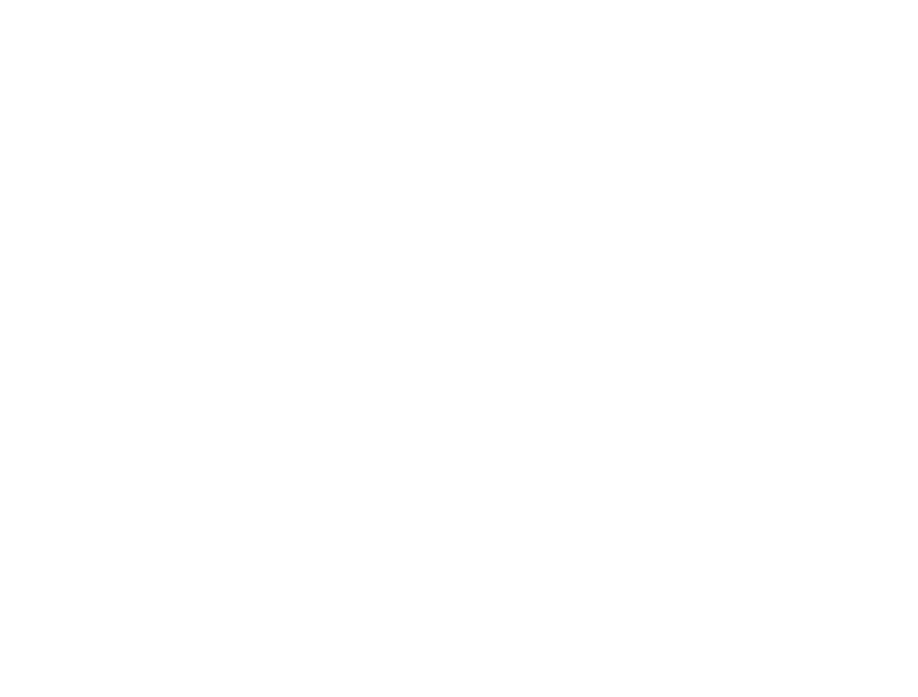

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.imshow(labeled_2['train_io']['outputs'], cmap='hot', interpolation='nearest')
plt.show()